# SQuAD1.1 - Data Analysis

## Summary

Describe the SQuAD1.1 dataset in:
* Structure and volume of the data
* Term-frequency and TF-IDF of contexts and questions respectively
* Text length  of contexts and questions respectively

## Setup

In [1]:
%%bash
# Dowload the SQuAD1.1 data
curl -O https://data.deepai.org/squad1.1.zip
unzip -o squad1.1.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8937k  100 8937k    0     0  3583k      0  0:00:02  0:00:02 --:--:-- 3582k


Archive:  squad1.1.zip
  inflating: data/dev-v1.1.json      
  inflating: data/train-v1.1.json    


In [2]:
# %%bash
#####################################################################
# Only use on Googgle Colab, uncomment if necessary
#####################################################################
# Clone the repo content into
# cd /content
# rm -rf deepqa
# git clone -b data_analysis https://github.com/PaulBeuran/deepqa.git

In [3]:
#####################################################################
# Only use on Googgle Colab, uncomment if necessary
#####################################################################
#%cd deepqa/notebooks/

In [4]:
import sys
import os
import pathlib

import json
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import wordcloud
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

plt.ioff()

deepqa_lib_path = str(pathlib.Path(os.getcwd()).parent.parent.absolute())
sys.path.insert(0, deepqa_lib_path)

from deepqa import preprocessing, analysis

In [5]:
# Read train and dev data
with open("data/train-v1.1.json", "rb") as j:
    train_data = json.load(j)["data"]
with open("data/dev-v1.1.json", "rb") as j:
    dev_data = json.load(j)["data"]

## Preprocessing

The data is constitued as a nested dictionary, stuctured as:
* `title` (ex: *World War 2*)
* `paragraphs`, a list of where each element is constitued of:
    * `context`, a piece of text used to contextualize the questions as a knowledge base on them (ex: *WW2 happened in 1939 to 1945, etc...*)
    * `qas`, listing all QAs in a list, as:
        * `question` (ex: *When did happened WW2 ?*)
        * `id`, as a hexadecimal code
        * `answers` or `plausible_answers`, the list of answers (or at least plausible ones), made of:
            * `text` (ex: *1939 to 1945*)
            * `answer_start`, indicating at what character index start the answer (ex: *16*)
        * `is_impossible`, a boolean indicating if the question is impossible ton answer

We will process it in two ways to be directly used for our data analysis:

* *Unwrapping*: transform the dictionary into 4 lists containing respectively each unique
subjects' titles, subjects' contexts, contexts' questions and questions' first answers
* *Tabularize*: transform the dictionary into a table-like double list, where each element
of the first list is an example containing all data rooting from an answer. As such, each
nested list contains a title, a context, a question and an answer, where the first 3 elements
can be repeated across examples (as in a table like a pandas' Dataframe)

In [6]:
titles, contexts, queries, answers = preprocessing.unwrap_squad11_data(train_data)
squad11_table = preprocessing.tabularize_squad11_data(train_data, row_wise_output=True)

False


## Data structure and volumes

We'll first print a random example from the training data in its tabular form.

In [7]:
# Run this cell to get random examples
rand_idx = np.random.randint(len(squad11_table))
title, context, query, answer = squad11_table[rand_idx]
print(f"Title: {title}\n")
print(f"Context: {context}\n")
print(f"Query: {query}\n")
print(f"Answer {answer}")

Title: Iran

Context: By the 1500s, Ismail I from Ardabil, established the Safavid Dynasty, with Tabriz as the capital. Beginning with Azerbaijan, he subsequently extended his authority over all of the Iranian territories, and established an intermittent Iranian hegemony over the vast relative regions, reasserting the Iranian identity within large parts of the Greater Iran. Iran was predominantly Sunni, but Ismail instigated a forced conversion to the Shia branch of Islam, by which the Shia Islam spread throughout the Safavid territories in the Caucasus, Iran, Anatolia, and Mesopotamia. As a result, thereof, the modern-day Iran is the only official Shia nation of the world, with it holding an absolute majority in Iran and the Republic of Azerbaijan, having there the 1st and 2nd highest number of Shia inhabitants by population percentage in the world.

Query: Who established the Safavid Dynasty?

Answer {'answer_start': 14, 'text': 'Ismail I from Ardabil'}


Except for the answer, all the elements are just textual data, in particular the context and the query.

As the SQuAD1.1 data goal is to find within the context which words answer a given query, the target, represented by the answer, has to be some part of the text, given here by the answer start character-wise and the answer, which can give the answer end by the length of it.

In [8]:
# Print volumes
print(f"# of titles: {len(titles)}")
print(f"# of contexts: {len(contexts)}")
print(f"# of queries: {len(queries)}")
print(f"# of contexts per titles {round(len(contexts)/len(titles), 3)}")
print(f"# of queries per contexts {round(len(queries)/len(contexts), 3)}")

# of titles: 442
# of contexts: 18896
# of queries: 87599
# of contexts per titles 42.751
# of queries per contexts 4.636


Data seem to be plentiful, with almost 88,000 context-query-answer triples, with an average of 4.6 query per contexts

## Term frequency

We will look now in the term frequency for contexts and queries respectively. Our goal is to have some general ideas what the contexts and the queries contains. 

To compute the term frequencies for each corpus (contexts and queries respectively), we will first split the text in terms tokens, using a tokenizer. The tokenizer used here is a simple regular expression extracting white-space and punctuantion-ridden seperated text chunks, whether they are true english words, numbers or a character amalgation without direct meaning.

The term frequencies will be then displayed on a wordcloud plot, the size and color of the words indicating its frequency.

The analysis for each corpus can be described as:
* For the contexts' corpus, we are looking to understand their general content and subject but not their structure. Therefore, we choose to plot the top-200 TF-IDF terms without stopwords, 1 and 2-grams respectively.
* For the queries corpus, we are looking for the structure instead and see what type of queries need to be answered. Therefore, we choose to plot the top-200 TF-IDF with stopwords, 1 and 2-grams respectively

In [9]:
contexts_terms_1g_tf_idf = preprocessing.get_corpus_tf_idf_word_frequencies(contexts, 
                                                                            stop_words="english", 
                                                                            sublinear_tf=True)
contexts_terms_2g_tf_idf = preprocessing.get_corpus_tf_idf_word_frequencies(contexts, 
                                                                            stop_words="english", 
                                                                            ngram_range=(2, 2),
                                                                            sublinear_tf=True)
queries_terms_1g_tf_idf = preprocessing.get_corpus_tf_idf_word_frequencies(queries,
                                                                           sublinear_tf=True)
queries_terms_2g_tf_idf = preprocessing.get_corpus_tf_idf_word_frequencies(queries,
                                                                           ngram_range=(2, 2),
                                                                           sublinear_tf=True)

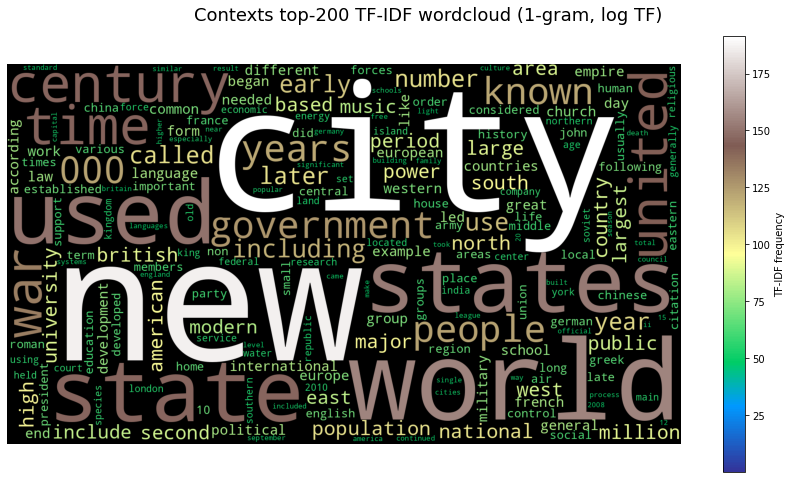

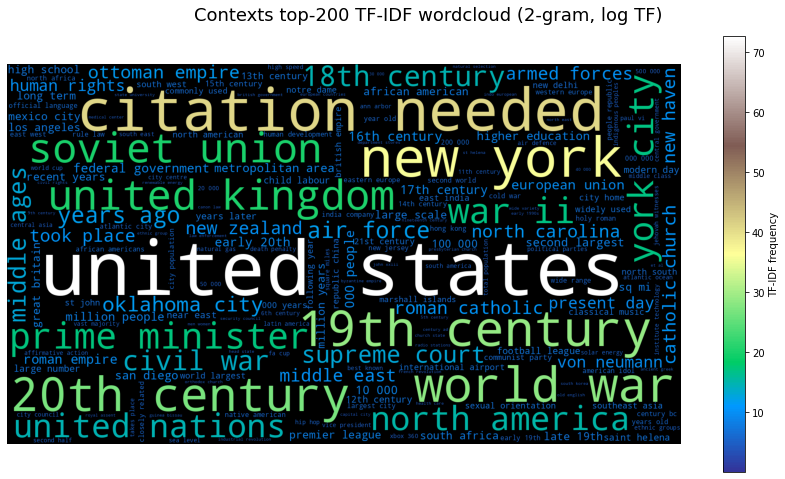

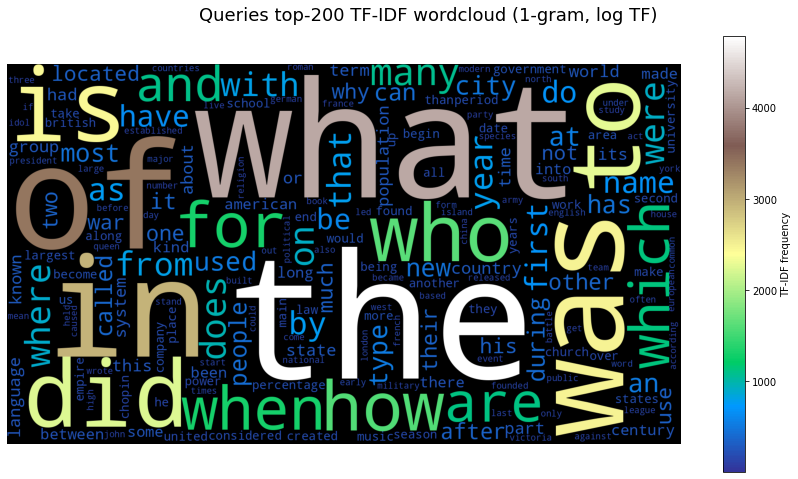

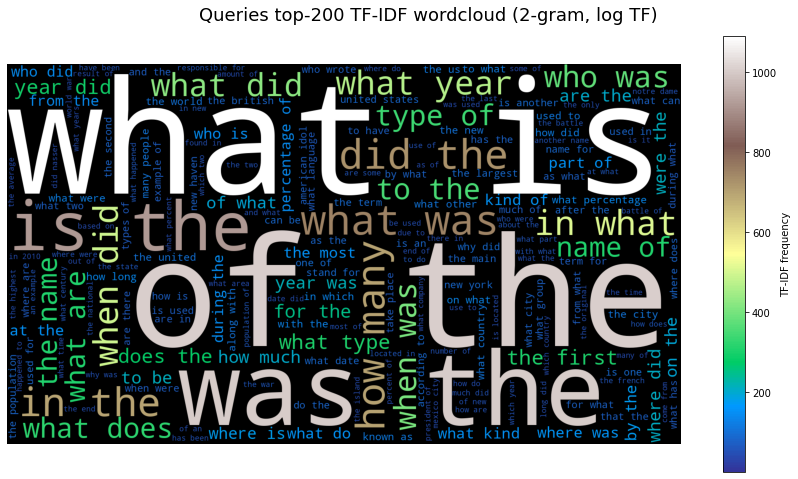

In [10]:
wordcloud_plot_kwargs_list = [
    {"terms_tf_idf": contexts_terms_1g_tf_idf,
     "title": "Contexts top-200 TF-IDF wordcloud (1-gram, log TF)"},
    {"terms_tf_idf": contexts_terms_2g_tf_idf,
     "title": "Contexts top-200 TF-IDF wordcloud (2-gram, log TF)"},
    {"terms_tf_idf": queries_terms_1g_tf_idf,
     "title": "Queries top-200 TF-IDF wordcloud (1-gram, log TF)"},
    {"terms_tf_idf": queries_terms_2g_tf_idf,
     "title": "Queries top-200 TF-IDF wordcloud (2-gram, log TF)"}
]

for wordcloud_plot_kwargs in wordcloud_plot_kwargs_list:
    analysis.top_tf_idf_wordcloud_plot(**wordcloud_plot_kwargs)
    plt.tight_layout()
    plt.show()

The wordcloud plots shows us a few things:
- Contexts' contents are about places ("city", "state"/"states", "world", "united states" etc...), time periods ("century", "middle ages", "time", "19th century", etc...), historical organisations or characters ("soviet union", "ottoman empire", "catholic church", "von neumann",  etc...), political/governmental organisations or characters ("governement", "prime minister", "federal state", "army"/"armed forces", "party", etc...), contextual terms ("early", "widely used", "took place", etc...), quantitative and qualitative terms ("millions", "new", etc...). This seems adequate given the data source (Wikipedia) and its uses (to assert a context for queries linked to it to be able to answer them).

<s></s>

- Queries structure seems to be always interrogative, with wh-words seeming to be very common ("what", "when", "who", "how") and contextual terms ("the first", "part of", "many people", "name of", etc...), which fit the goal of those queries and the content of the contexts linked to them.

<s></s>

- As the tokenizer extract all the white-space seperated character chunks in both texts, there can be a few anomalies. As such, we can see a "000" token, which seems to be very reccurent in the contexts. This come from the fact that a lot of numbers are written with a whitespace between the hundreds and the thousands or the thousands and the millions, and the numbers are often rounded to the hundreds. Another anomaly would be the "citation needed" term high frequency, coming from the Wikipedia's source template which seems to have been saved during the contexts scraping.

## Text lengths

We will look now for text lenghts distribution in term tokens to identify what preprocessing would be needed in order to use some deep learning models like BeRT.

We will use the same tokenization process as in the term frequencies analysis.

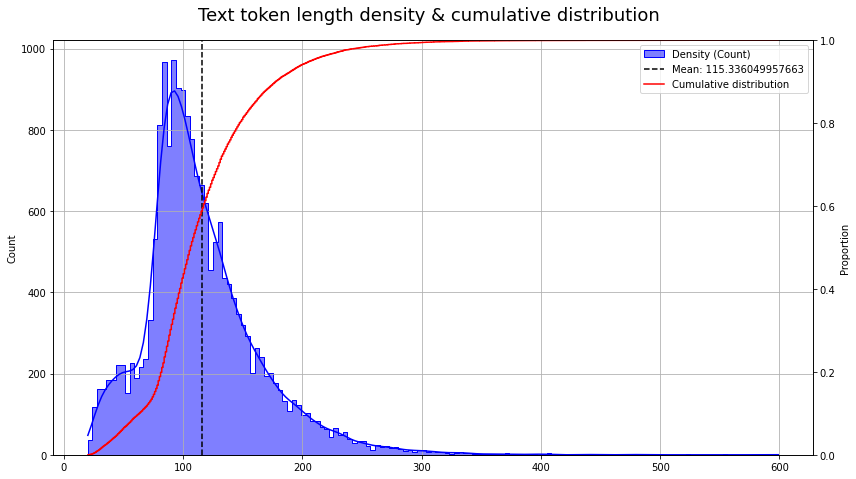

In [11]:
analysis.text_token_length_distribution_plot(contexts)
plt.tight_layout()
plt.show()

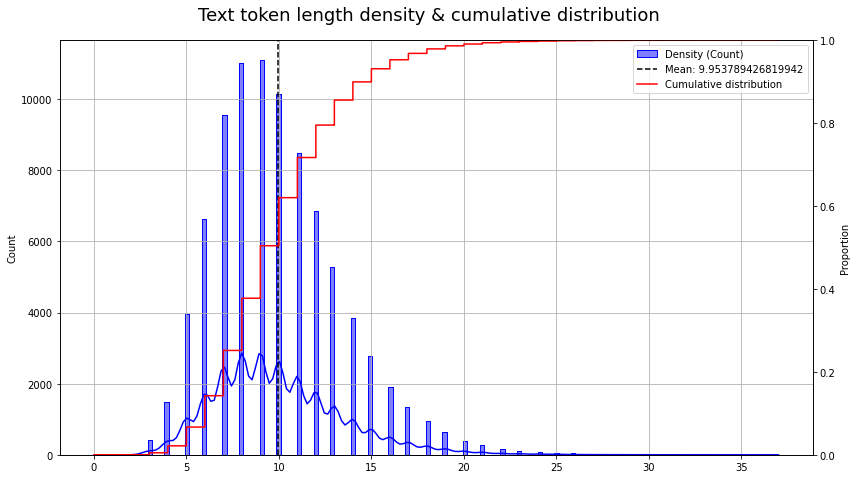

In [12]:
analysis.text_token_length_distribution_plot(queries)
plt.tight_layout()
plt.show()

Both texts lenghts distribution seems to be Gaussian-like, with the density mass concentrated almost around the mean.

Contexts lenghts are bigger than queries ones, as a query is directly linked through the answer to a subset of the text, therefore a context having more information than needed to answer the query.

The max lenghts for both respectively seems to be 600 and 37 terms. While queries of this lenght are easily handled, contexts with a max length of 600 can be hard to embed using deep learning techniques, as most of the state-of-the-art context encoder like BERT can handle at most sequence of 512 terms. However, it seems that contexts that long are quite rare, and if we were to remove all the contexts with a term length greater than 512, we will still keep more than 99% of our observations. 

Therefore, it is advised to consider the contexts to have a max term length of 512 and queries a max term length of 64, with all the terms exceeding those limits to be cut.